In [ ]:
import argparse
import torch
import numpy
np = numpy
import pdb
import torch.nn.functional as F

# from models.py
import numpy as np
import torch
import math
import pdb
from sklearn.linear_model import LinearRegression
from itertools import chain, combinations
from scipy.stats import f as fdist
from scipy.stats import ttest_ind
import torch.nn.functional as F
#
from torch.autograd import grad
#
import scipy.optimize
#
import matplotlib
import matplotlib.pyplot as plt



def pretty(vector):
    vlist = vector.view(-1).tolist()
    return "[" + ", ".join("{:+.3f}".format(vi) for vi in vlist) + "]"

### Yahuan Zheng: added for pretty print
def pretty_print(*values):
    col_width = 20
    def format_val(v):
        if not isinstance(v, str):
          v = np.array2string(v, precision=5, floatmode='fixed')
        return v.ljust(col_width)
    str_values = [format_val(v) for v in values]
    print("   ".join(str_values))



def errors(w, w_hat):
    w = w.view(-1)
    w_hat = w_hat.view(-1)

    i_causal = (w != 0).nonzero().view(-1)
    i_noncausal = (w == 0).nonzero().view(-1)
    cosine = torch.nn.CosineSimilarity(dim=0)

    if len(i_causal):
        mse_causal = (w[i_causal] - w_hat[i_causal]).pow(2).mean()
        mse_causal = mse_causal.item()
        cosine_causal = cosine(w[i_causal], w_hat[i_causal]).item()
    else:
        mse_causal = 0
        cosine_noncausal = 0

    if len(i_noncausal):
        mse_noncausal = (w[i_noncausal] - w_hat[i_noncausal]).pow(2).mean()
        mse_noncausal = mse_noncausal.item()
        cosine_noncausal = cosine(w[i_noncausal], w_hat[i_noncausal]).item()
    else:
        mse_noncausal = 0
        cosine_noncausal = 0

    return mse_causal, mse_noncausal, cosine_causal, cosine_noncausal


def set_device():
    if torch.cuda.is_available():
      dev = "cuda:0"
    else:
      dev = "cpu"
    return torch.device(dev)


# Yahuan Zheng: Changed the return value here to include the hidden variables
# Define the structural equation model
class ChainEquationModel(object):
    def __init__(self, dim, args, scramble=False, hetero=True, hidden=False):
        self.hetero = hetero
        self.hidden = hidden
        self.dim = dim // 2 # UGLY!
        ones = args["env_ones"]
        self.args = args

        if ones:
            self.wxy = torch.eye(self.dim)
            self.wyz = torch.eye(self.dim)
        else:
            self.wxy = torch.randn(self.dim, self.dim) / dim
            self.wyz = torch.randn(self.dim, self.dim) / dim

        if scramble:
            self.scramble, _ = torch.qr(torch.randn(dim, dim))
        else:
            self.scramble = torch.eye(dim)

        if hidden:
            self.whx = torch.randn(self.dim, self.dim) / dim
            self.why = torch.randn(self.dim, self.dim) / dim
            self.whz = torch.randn(self.dim, self.dim) / dim
        else:
            #self.whx = torch.eye(self.dim, self.dim)
            self.whx = torch.zeros(self.dim, self.dim)
            self.why = torch.zeros(self.dim, self.dim)
            self.whz = torch.zeros(self.dim, self.dim)

    def solution(self):
        w = torch.cat((self.wxy.sum(1), torch.zeros(self.dim))).view(-1, 1)
        return self.scramble.t() @ w

    def __call__(self, n, env):
        h = torch.randn(n, self.dim) * env
        x = h @ self.whx + torch.randn(n, self.dim) * env

        if self.hetero:
            y = x @ self.wxy + h @ self.why + torch.randn(n, self.dim) * env
            z = y @ self.wyz + h @ self.whz + torch.randn(n, self.dim)
        else:
            y = x @ self.wxy + h @ self.why + torch.randn(n, self.dim)
            z = y @ self.wyz + h @ self.whz + torch.randn(n, self.dim) * env

        return torch.cat((x, z), 1) @ self.scramble, y.sum(1, keepdim=True), h      # Yahuan Zheng: added the last variable as anchor (can be changed)


In [ ]:
# Define the methods used for comparison

class REX_0(object):

    def __init__(self, environments, args, sem):
        best_reg = 0
        best_err = 1e6

        self.args = args

        x_val = environments[-1][0]
        y_val = environments[-1][1]

        reg = args["reg"]
        if reg == -1:
            regs = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
        else:
            regs = [reg]

        for reg in regs:
            self.train(environments, args, reg=reg)
            err = (x_val @ self.solution() - y_val).pow(2).mean().item()

            if 1:#args["verbose"]:
                print("  -- REX (reg={:.5f}) has {:.3f} validation error.".format(
                    reg, err))

            if err < best_err:
                best_err = err
                best_reg = reg
                best_phi = self.phi.clone()
        self.phi = best_phi
        print("Best reg is {:.5f} with {:.3f} validation error.".format(best_reg, best_err))

    def compute_REX_penalty(self, loss1, loss2, clip):
        if self.args["penalty"] == "MAE":
            return ((torch.clamp(loss1, clip) - torch.clamp(loss2, clip))**2)**.5
        elif self.args["penalty"] == "MSE":
            return ((torch.clamp(loss1, clip) - torch.clamp(loss2, clip))**2)
        else:
            assert False # TODO

    def train(self, environments, args, reg=0, use_cuda=True):
        device = set_device()
        baselines = [0 for env in environments]
        self.baselines = baselines

        self.rs = []
        self.r1s = []
        self.r2s = []
        self.r3s = []
        if args["monitor_test_MSE"]:
            self.test_MSE_causal = []
            self.test_MSE_noncausal = []
        # TODO:
        self.rs_clipped = []
        self.r1s_clipped = []
        self.r2s_clipped = []
        self.r3s_clipped = []
        #
        self.phis = []

        dim_x = environments[0][0].size(1)
        self.dim_x = dim_x

        self.w = torch.ones(dim_x, 1).to(device)
        self.w.requires_grad = False
        if args["use_IRM_parametrization"] == 1:
            assert False # TODO: (what do I need to do here???)
            self.phi = torch.nn.Parameter(torch.eye(dim_x,dim_x) + args["init_noise"]*torch.randn(dim_x, dim_x))
            self.weights = self.phi @ self.w
        else:
            self.phi = torch.nn.Parameter(torch.ones(dim_x,1) + args["init_noise"]*torch.randn(dim_x,1))
            self.weights = self.phi

        #opt = torch.optim.SGD([self.phi], lr=0.01, momentum=0.9) #args["lr"])
        opt = torch.optim.Adam([self.phi], lr=args["lr"])
        MSE = torch.nn.MSELoss()

        for iteration in range(args["n_iterations"]):

            clip = args["clip"]
            if iteration > args["clip_until"]:
                clip = -np.inf

            if args["use_IRM_parametrization"] == 1:
                weights = self.phi @ torch.ones(dim_x, 1)
            else:
                weights = self.phi
            penalty = 0
            error = 0

            #x_e_1, y_e_1 = environments[0]
            #x_e_2, y_e_2 = environments[1]
            x_e_1, y_e_1, a_e_1 = environments[0]
            x_e_2, y_e_2, a_e_2 = environments[1]

            yhat1 = x_e_1 @ weights
            yhat2 = x_e_2 @ weights
            r1 = MSE(yhat1, y_e_1) - baselines[0]
            r2 = MSE(yhat2, y_e_2) - baselines[1]
            # validation
            # x_e_3, y_e_3 = environments[2]
            x_e_3, y_e_3, a_e_3 = environments[2]
            r3 = MSE(x_e_3 @ weights, y_e_3) - baselines[2]

            if args["print_clipped"]:
                r1 = torch.clamp(r1, clip)
                r2 = torch.clamp(r2, clip)
                r3 = torch.clamp(r3, clip)

            # learning curves
            self.rs.append(r1+r2)
            self.r1s.append(r1)
            self.r2s.append(r2)
            self.r3s.append(r3)
            #self.phis.append(self.weights)
            self.phis.append(weights)


            # COMPUTE LOSS
            loss = 0.0
            penalty = (self.compute_REX_penalty(r1, r2, clip)).to(device)
            error = r1 + r2 # N.B.: NOT USING VALIDATION ENVIRONMENT
            loss += error
            loss += args["L2_reg"] * self.phi.pow(2).sum().sqrt()
            loss = reg * loss + (1 - reg) * penalty
            loss = loss.to(device)

            opt.zero_grad()
            loss.backward()
            opt.step()

            if args["verbose"] and iteration % args["print_rate"] == 0:
                w_str = pretty(self.solution())
                w_norm = self.phi.pow(2).sum().sqrt()
                if args["monitor_test_MSE"]:
                    test_MSE_causal, test_MSE_noncausal, _, _ = errors(sem.solution(), weights).to(device)
                    self.test_MSE_causal.append(test_MSE_causal)
                    self.test_MSE_noncausal.append(test_MSE_noncausal)
                    print("it: {:05d} | test_MSE_causal: {:.5f} | test_MSE_noncausal: {:.5f} | reg: {:.5f} | loss: {:.5f} | r1: {:.5f} | r2: {:.5f} | w_norm: {:.5f} | {}".format(iteration,
                                                                        test_MSE_causal,
                                                                        test_MSE_noncausal,
                                                                        reg,
                                                                        loss,
                                                                        r1,
                                                                        r2,
                                                                        w_norm,
                                                                        w_str))
                else:
                    print("it: {:05d} | reg: {:.5f} | loss: {:.5f} | r1: {:.5f} | r2: {:.5f} | w_norm: {:.5f} | {}".format(iteration,
                                                                        reg,
                                                                        loss,
                                                                        r1,
                                                                        r2,
                                                                        w_norm,
                                                                        w_str))
    def solution(self):
        if self.args["use_IRM_parametrization"] == 1:
            return self.phi @ self.w
        else:
            return self.phi



class REX_var(object):

    def __init__(self, environments, args, sem):
        best_reg = 0
        best_err = 1e6

        self.args = args

        x_val = environments[-1][0]
        y_val = environments[-1][1]

        reg = args["reg"]
        if reg == -1:
            regs = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
        else:
            regs = [reg]

        for reg in regs:
            self.train(environments, args, reg=reg)
            err = (x_val @ self.solution() - y_val).pow(2).mean().item()

            if 1:#args["verbose"]:
                print("  -- REX_var (reg={:.5f}) has {:.3f} validation error.".format(
                    reg, err))

            if err < best_err:
                best_err = err
                best_reg = reg
                best_phi = self.phi.clone()
        self.phi = best_phi
        print("Best reg is {:.5f} with {:.3f} validation error.".format(best_reg, best_err))

    def compute_REX_penalty(self, loss1, loss2, clip):
        if self.args["penalty"] == "MAE":
            return ((torch.clamp(loss1, clip) - torch.clamp(loss2, clip))**2)**.5
        elif self.args["penalty"] == "MSE":
            return ((torch.clamp(loss1, clip) - torch.clamp(loss2, clip))**2)
        else:
            assert False # TODO

    def train(self, environments, args, reg=0, use_cuda=True):
        device = set_device()
        if 1:#args["baseline"] == "var(Y)" or args["baseline"] == "var(Y)-var(Y^)":
            baselines = [torch.var(env[1]) for env in environments]
        self.baselines = baselines

        self.rs = []
        self.r1s = []
        self.r2s = []
        self.r3s = []
        if args["monitor_test_MSE"]:
            self.test_MSE_causal = []
            self.test_MSE_noncausal = []
        # TODO:
        self.rs_clipped = []
        self.r1s_clipped = []
        self.r2s_clipped = []
        self.r3s_clipped = []
        #
        self.phis = []

        dim_x = environments[0][0].size(1)
        self.dim_x = dim_x

        self.w = torch.ones(dim_x, 1).to(device)
        self.w.requires_grad = False
        if args["use_IRM_parametrization"] == 1:
            assert False
            self.phi = torch.nn.Parameter(torch.eye(dim_x,dim_x) + args["init_noise"]*torch.randn(dim_x, dim_x))
            self.weights = self.phi @ self.w
        else:
            self.phi = torch.nn.Parameter(torch.ones(dim_x,1) + args["init_noise"]*torch.randn(dim_x,1))
            self.weights = self.phi

        #opt = torch.optim.SGD([self.phi], lr=0.01, momentum=0.9) #args["lr"])
        opt = torch.optim.Adam([self.phi], lr=args["lr"])
        MSE = torch.nn.MSELoss()

        for iteration in range(args["n_iterations"]):

            clip = args["clip"]
            if iteration > args["clip_until"]:
                clip = -np.inf

            if args["use_IRM_parametrization"] == 1:
                weights = self.phi @ torch.ones(dim_x, 1)
            else:
                weights = self.phi
            penalty = 0
            error = 0

            #x_e_1, y_e_1 = environments[0]
            #x_e_2, y_e_2 = environments[1]
            x_e_1, y_e_1, a_e_1 = environments[0]
            x_e_2, y_e_2, a_e_2 = environments[1]

            yhat1 = x_e_1 @ weights
            yhat2 = x_e_2 @ weights
            r1 = MSE(yhat1, y_e_1) - baselines[0]
            r2 = MSE(yhat2, y_e_2) - baselines[1]
            if 1:#elif args["baseline"] == "var(Y^)":
                r1 -= torch.var(yhat1)
                r2 -= torch.var(yhat2)
            # validation
            # x_e_3, y_e_3 = environments[2]
            x_e_3, y_e_3, a_e_3 = environments[2]
            r3 = MSE(x_e_3 @ weights, y_e_3) - baselines[2]

            if args["print_clipped"]:
                r1 = torch.clamp(r1, clip)
                r2 = torch.clamp(r2, clip)
                r3 = torch.clamp(r3, clip)

            # learning curves
            self.rs.append(r1+r2)
            self.r1s.append(r1)
            self.r2s.append(r2)
            self.r3s.append(r3)
            #self.phis.append(self.weights)
            self.phis.append(weights)


            # COMPUTE LOSS
            loss = 0.0
            penalty = (self.compute_REX_penalty(r1, r2, clip)).to(device)
            error = r1 + r2 # N.B.: NOT USING VALIDATION ENVIRONMENT
            loss += error
            loss += args["L2_reg"] * self.phi.pow(2).sum().sqrt()
            loss = reg * loss + (1 - reg) * penalty
            loss = loss.to(device)

            opt.zero_grad()
            loss.backward()
            opt.step()

            if args["verbose"] and iteration % args["print_rate"] == 0:
                w_str = pretty(self.solution())
                w_norm = self.phi.pow(2).sum().sqrt()
                if args["monitor_test_MSE"]:
                    test_MSE_causal, test_MSE_noncausal, _, _ = errors(sem.solution(), weights).to(device)
                    self.test_MSE_causal.append(test_MSE_causal)
                    self.test_MSE_noncausal.append(test_MSE_noncausal)
                    print("it: {:05d} | test_MSE_causal: {:.5f} | test_MSE_noncausal: {:.5f} | reg: {:.5f} | loss: {:.5f} | r1: {:.5f} | r2: {:.5f} | w_norm: {:.5f} | {}".format(iteration,
                                                                        test_MSE_causal,
                                                                        test_MSE_noncausal,
                                                                        reg,
                                                                        loss,
                                                                        r1,
                                                                        r2,
                                                                        w_norm,
                                                                        w_str))
                else:
                    print("it: {:05d} | reg: {:.5f} | loss: {:.5f} | r1: {:.5f} | r2: {:.5f} | w_norm: {:.5f} | {}".format(iteration,
                                                                        reg,
                                                                        loss,
                                                                        r1,
                                                                        r2,
                                                                        w_norm,
                                                                        w_str))
    def solution(self):
        if self.args["use_IRM_parametrization"] == 1:
            return self.phi @ self.w
        else:
            return self.phi



class REX_var_diff(object):

    def __init__(self, environments, args, sem):
        best_reg = 0
        best_err = 1e6

        self.args = args

        x_val = environments[-1][0]
        y_val = environments[-1][1]

        reg = args["reg"]
        if reg == -1:
            regs = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
        else:
            regs = [reg]

        for reg in regs:
            self.train(environments, args, reg=reg)
            err = (x_val @ self.solution() - y_val).pow(2).mean().item()

            if 1:#args["verbose"]:
                print("  -- REX_var_diff (reg={:.5f}) has {:.3f} validation error.".format(
                    reg, err))

            if err < best_err:
                best_err = err
                best_reg = reg
                best_phi = self.phi.clone()
        self.phi = best_phi
        print("Best reg is {:.5f} with {:.3f} validation error.".format(best_reg, best_err))

    def compute_REX_penalty(self, loss1, loss2, clip):
        if self.args["penalty"] == "MAE":
            return ((torch.clamp(loss1, clip) - torch.clamp(loss2, clip))**2)**.5
        elif self.args["penalty"] == "MSE":
            return ((torch.clamp(loss1, clip) - torch.clamp(loss2, clip))**2)
        else:
            assert False # TODO

    def train(self, environments, args, reg=0, use_cuda=True):
        device = set_device()
        if 1:#args["baseline"] == "var(Y)" or args["baseline"] == "var(Y)-var(Y^)":
            baselines = [torch.var(env[1]) for env in environments]
        self.baselines = baselines

        self.rs = []
        self.r1s = []
        self.r2s = []
        self.r3s = []
        if args["monitor_test_MSE"]:
            self.test_MSE_causal = []
            self.test_MSE_noncausal = []
        # TODO:
        self.rs_clipped = []
        self.r1s_clipped = []
        self.r2s_clipped = []
        self.r3s_clipped = []
        #
        self.phis = []

        dim_x = environments[0][0].size(1)
        self.dim_x = dim_x

        self.w = torch.ones(dim_x, 1).to(device)
        self.w.requires_grad = False
        if args["use_IRM_parametrization"] == 1:
            assert False
            self.phi = torch.nn.Parameter(torch.eye(dim_x,dim_x) + args["init_noise"]*torch.randn(dim_x, dim_x))
            self.weights = self.phi @ self.w
        else:
            self.phi = torch.nn.Parameter(torch.ones(dim_x,1) + args["init_noise"]*torch.randn(dim_x,1))
            self.weights = self.phi

        #opt = torch.optim.SGD([self.phi], lr=0.01, momentum=0.9) #args["lr"])
        opt = torch.optim.Adam([self.phi], lr=args["lr"])
        MSE = torch.nn.MSELoss()

        for iteration in range(args["n_iterations"]):

            clip = args["clip"]
            if iteration > args["clip_until"]:
                clip = -np.inf

            if args["use_IRM_parametrization"] == 1:
                weights = self.phi @ torch.ones(dim_x, 1)
            else:
                weights = self.phi
            penalty = 0
            error = 0

            #x_e_1, y_e_1 = environments[0]
            #x_e_2, y_e_2 = environments[1]
            x_e_1, y_e_1, a_e_1 = environments[0]
            x_e_2, y_e_2, a_e_2 = environments[1]

            yhat1 = x_e_1 @ weights
            yhat2 = x_e_2 @ weights
            r1 = MSE(yhat1, y_e_1) - baselines[0]
            r2 = MSE(yhat2, y_e_2) - baselines[1]
            if 1:#args["baseline"] == "var(Y)-var(Y^)":
                var1 = torch.var(yhat1)
                var2 = torch.var(yhat2)
                if args["detach"]:
                    var1.detach()
                    var2.detach()
                r1 += var1
                r2 += var2
            # validation
            #x_e_3, y_e_3 = environments[2]
            x_e_3, y_e_3, a_e_3 = environments[2]
            r3 = MSE(x_e_3 @ weights, y_e_3) - baselines[2]

            if args["print_clipped"]:
                r1 = torch.clamp(r1, clip)
                r2 = torch.clamp(r2, clip)
                r3 = torch.clamp(r3, clip)

            # learning curves
            self.rs.append(r1+r2)
            self.r1s.append(r1)
            self.r2s.append(r2)
            self.r3s.append(r3)
            #self.phis.append(self.weights)
            self.phis.append(weights)


            # COMPUTE LOSS
            loss = 0.0
            penalty = (self.compute_REX_penalty(r1, r2, clip)).to(device)
            error = r1 + r2 # N.B.: NOT USING VALIDATION ENVIRONMENT
            loss += error
            loss += args["L2_reg"] * self.phi.pow(2).sum().sqrt()
            loss = reg * loss + (1 - reg) * penalty
            loss = loss.to(device)

            opt.zero_grad()
            loss.backward()
            opt.step()

            if args["verbose"] and iteration % args["print_rate"] == 0:
                w_str = pretty(self.solution())
                w_norm = self.phi.pow(2).sum().sqrt()
                if args["monitor_test_MSE"]:
                    test_MSE_causal, test_MSE_noncausal, _, _ = errors(sem.solution(), weights).to(device)
                    self.test_MSE_causal.append(test_MSE_causal)
                    self.test_MSE_noncausal.append(test_MSE_noncausal)
                    print("it: {:05d} | test_MSE_causal: {:.5f} | test_MSE_noncausal: {:.5f} | reg: {:.5f} | loss: {:.5f} | r1: {:.5f} | r2: {:.5f} | w_norm: {:.5f} | {}".format(iteration,
                                                                        test_MSE_causal,
                                                                        test_MSE_noncausal,
                                                                        reg,
                                                                        loss,
                                                                        r1,
                                                                        r2,
                                                                        w_norm,
                                                                        w_str))
                else:
                    print("it: {:05d} | reg: {:.5f} | loss: {:.5f} | r1: {:.5f} | r2: {:.5f} | w_norm: {:.5f} | {}".format(iteration,
                                                                        reg,
                                                                        loss,
                                                                        r1,
                                                                        r2,
                                                                        w_norm,
                                                                        w_str))
    def solution(self):
        if self.args["use_IRM_parametrization"] == 1:
            return self.phi @ self.w
        else:
            return self.phi




class InvariantRiskMinimization(object):
    def __init__(self, environments, args, sem):
        best_reg = 0
        best_err = 1e6
        self.sem = sem
        self.args = args

        x_val = environments[-1][0]
        y_val = environments[-1][1]

        reg = args["reg"]
        if reg == -1:
            regs = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
        else:
            regs = [reg]

        for reg in regs:
            self.train(environments[:-1], args, reg=reg)
            err = (x_val @ self.solution() - y_val).pow(2).mean().item()

            if 1:#args["verbose"]:
                print("  -- IRM (reg={:.5f}) has {:.3f} validation error.".format(
                    reg, err))

            if err < best_err:
                best_err = err
                best_reg = reg
                best_phi = self.phi.clone()
        self.phi = best_phi
        print("Best reg is {:.5f} with {:.3f} validation error.".format(best_reg, best_err))

    def train(self, environments, args, reg=0):
        device = set_device()
        dim_x = environments[0][0].size(1)
        if args["only_use_e1_with_IRM"]:
            environments = environments[:-1]

        #self.phi = torch.nn.Parameter(torch.eye(dim_x, dim_x))
        self.phi = torch.nn.Parameter(torch.eye(dim_x, dim_x) + args["init_noise"]*torch.randn(dim_x, dim_x))
        self.w = torch.ones(dim_x, 1)
        self.w.requires_grad = True

        self.r1s = []
        self.r2s = []
        if args["monitor_test_MSE"]:
            self.test_MSE_causal = []
            self.test_MSE_noncausal = []

        opt = torch.optim.Adam([self.phi], lr=args["lr"])
        loss_fcn = torch.nn.MSELoss()

        for iteration in range(args["n_iterations"]):
            penalty = 0
            error = 0
            n_env = 0
            for x_e, y_e, a_e in environments:
                n_env += 1
                #print("n_env=", n_env)
                error_e = loss_fcn(x_e @ self.phi @ self.w, y_e)
                if n_env == 1:
                    self.r1s.append(error_e)
                elif n_env == 2:
                    self.r2s.append(error_e)
                else:
                    assert False
                penalty += grad(error_e, self.w,
                                create_graph=True)[0].pow(2).mean()
                error += error_e
                loss = reg * error + (1 - reg) * penalty
                loss = loss.to(device)

            error += args["L2_reg"] * self.phi.pow(2).sum().sqrt()

            opt.zero_grad()
            loss.backward()
            opt.step()

            if args["verbose"] and iteration % 100 == 0:
                w_str = pretty(self.solution())
                w_norm = self.phi.pow(2).sum().sqrt()
                if args["monitor_test_MSE"]:
                    test_MSE_causal, test_MSE_noncausal, _, _ = errors(sem.solution(), self.phi @ self.w)
                    self.test_MSE_causal.append(test_MSE_causal)
                    self.test_MSE_noncausal.append(test_MSE_noncausal)
                    print("{:05d} | {:.5f} | {:.5f} | {:.5f} | {:.5f} | {:.5f} | {:.5f} | {}".format(iteration,
                                                                        test_MSE_causal,
                                                                        test_MSE_noncausal,
                                                                        reg,
                                                                        error,
                                                                        penalty,
                                                                        w_norm,
                                                                        w_str))
                else:
                    print("{:05d} | {:.5f} | {:.5f} | {:.5f} | {:.5f} | {}".format(iteration,
                                                                        reg,
                                                                        error,
                                                                        penalty,
                                                                        w_norm,
                                                                        w_str))

    def solution(self):
        return self.phi @ self.w



class EmpiricalRiskMinimization(object):
    def __init__(self, environments, args, sem):
        self.args = args
        self.sem = sem
        x_all = torch.cat([x for (x, y, _) in environments[:-1]]).numpy()
        y_all = torch.cat([y for (x, y, _) in environments[:-1]]).numpy()
        x_val = environments[-1][0]
        y_val = environments[-1][1]

        x_all = np.vstack(x_all)
        y_all = np.vstack(y_all)

        w = LinearRegression(fit_intercept=False).fit(x_all, y_all).coef_
        w = torch.Tensor(w)
        err = (x_val @ torch.t(w) - y_val).pow(2).mean().item()

        print("  -- ERM has {:.3f} validation error.".format(err))
        self.w = torch.t(w)

    def solution(self):
        return self.w

In [ ]:
# Yahuan Zheng: added the anchor regression class

class AnchorRegression(object):
    def __init__(self, environments, args, sem):
        best_reg = 0
        best_err = 1e6
        self.sem = sem
        self.args = args

        x_val = environments[-1][0]
        y_val = environments[-1][1]

        reg = args["reg"]
        if reg == -1:
            #regs = [0, 1, 2, 5, 10, 20]
            regs = np.linspace(0, 10, num= 101, endpoint = True)
        else:
            regs = [reg]

        for reg in regs:
            # print("the reg now is", reg)
            x_trans_all = []
            y_trans_all = []
            e_trans_all = []
            environments_trans = self.transform(environments[:-1], args, reg=reg)
            for env_i, (x_trans, y_trans) in enumerate(environments_trans):
              x_trans_all.append(x_trans.numpy())
              y_trans_all.append(y_trans.numpy())
              e_trans_all.append(np.full(x_trans.shape[0], env_i))
            x_trans_all = np.vstack(x_trans_all)
            y_trans_all = np.vstack(y_trans_all)
            e_trans_all = np.vstack(e_trans_all)

            w = LinearRegression(fit_intercept=False).fit(x_trans_all, y_trans_all).coef_
            w = torch.Tensor(w)
            #print(x_val.size())
            #print(w.shape)

            error_val = (x_val @ torch.t(w) - y_val).pow(2).mean().item()
            # print every 10 iterations
            if (reg % 1 == 0):
              print("  -- Anchor Regression (reg={:.1f}) has {:.3f} validation error.".format(
                      reg, error_val))

            if error_val < best_err:
                best_err = error_val
                best_reg = reg
                best_w = w.clone()

        self.w = torch.t(best_w)
        print("Best reg is {:.1f} with {:.3f} validation error.".format(best_reg, best_err))

        '''
            self.train(environments[:-1], args, reg=reg)
            err = (x_val @ self.solution() - y_val).pow(2).mean().item()

            if 1:#args["verbose"]:
                print("IRM (reg={:.5f}) has {:.3f} validation error.".format(
                    reg, err))

            if err < best_err:
                best_err = err
                best_reg = reg
                best_phi = self.phi.clone()

        self.phi = best_phi
        '''

    ### Yahuan Zheng: added the function to transform the x's and y's
    def transform(self, environments, args, reg=0):
        n_samples = environments[0][0].size(0)
        dim_x = environments[0][0].size(1)
        environments_trans = []

        for x_e, y_e, a_e in environments:
          a_t_a = torch.t(a_e) @ a_e
          a_t_a_inv = torch.linalg.inv(a_t_a)
          proj_mat = (a_e @ a_t_a_inv) @ torch.t(a_e)
          id = torch.eye(n_samples)
          gamma = torch.Tensor([reg])
          left_x = torch.sub(id, proj_mat) @ x_e
          left_y = torch.sub(id, proj_mat) @ y_e
          right_x = torch.mul(proj_mat @ x_e, gamma)
          right_y = torch.mul(proj_mat @ y_e, gamma)

          x_trans = torch.add(left_x, right_x)
          y_trans = torch.add(left_y, right_y)
          environments_trans.append([x_trans, y_trans])

        return environments_trans


    def solution(self):
        return self.w

-------------------------- Restart 1 --------------------------
Start trial 1 of 40
  -- ERM has 126.270 validation error.
Finished trial 1 of 40
Average time per trial = 0.2864978313446045 seconds

Start trial 2 of 40
  -- IRM (reg=0.00000) has 128.302 validation error.
  -- IRM (reg=0.00001) has 128.242 validation error.
  -- IRM (reg=0.00010) has 127.888 validation error.
  -- IRM (reg=0.00100) has 127.341 validation error.
  -- IRM (reg=0.01000) has 126.926 validation error.
  -- IRM (reg=0.10000) has 126.311 validation error.
Best reg is 0.10000 with 126.311 validation error.
Finished trial 2 of 40
Average time per trial = 45.68455243110657 seconds

Start trial 3 of 40
  -- REX (reg=0.00000) has 125.100 validation error.
  -- REX (reg=0.00001) has 124.251 validation error.
  -- REX (reg=0.00010) has 118.844 validation error.
  -- REX (reg=0.00100) has 115.710 validation error.
  -- REX (reg=0.01000) has 122.194 validation error.
  -- REX (reg=0.10000) has 118.493 validation error.

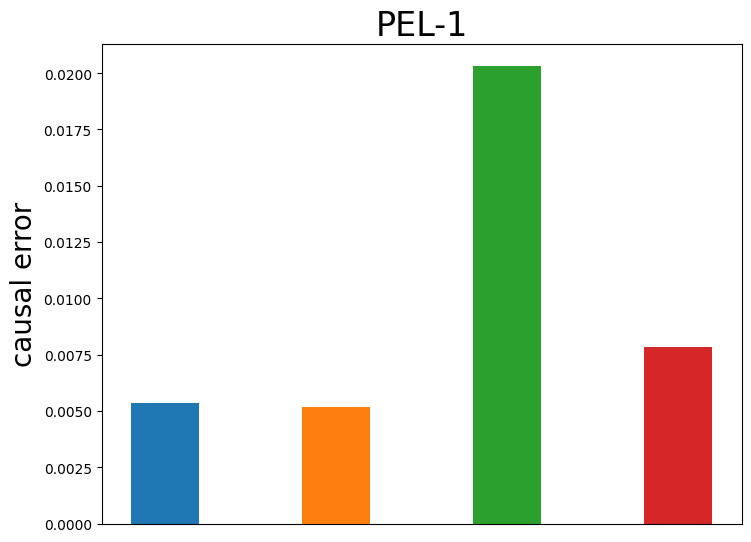

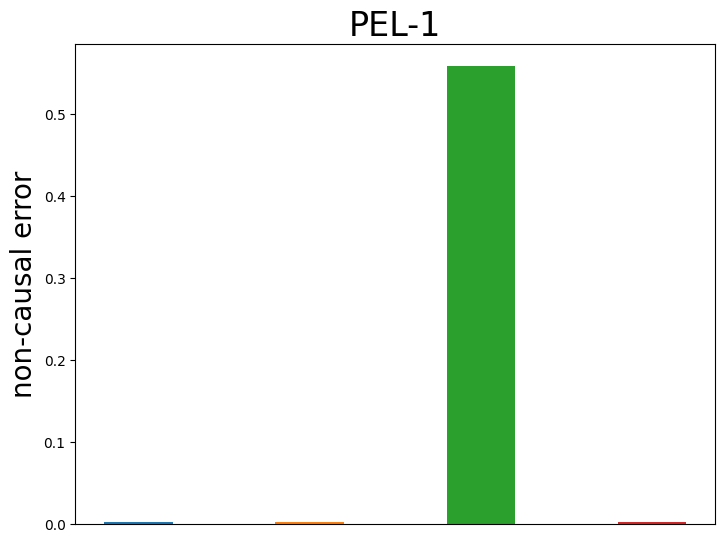

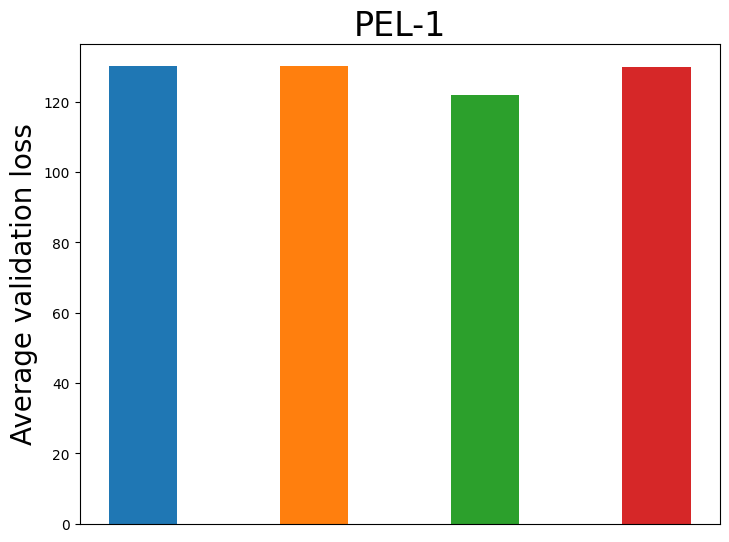

In [ ]:
# main

if 1:#__name__ == '__main__':
    parser = argparse.ArgumentParser(description='Invariant regression')
    parser.add_argument('--dim', type=int, default=10)
    parser.add_argument('--n_samples', type=int, default=1000)
    parser.add_argument('--n_reps', type=int, default=10)
    parser.add_argument('--skip_reps', type=int, default=0)
    parser.add_argument('--seed', type=int, default=0)  # Negative is random
    parser.add_argument('--print_vectors', type=int, default=1)
    parser.add_argument('--n_iterations', type=int, default=10000)
    parser.add_argument('--lr', type=float, default=1e-3)
    parser.add_argument('--verbose', type=int, default=0)
    parser.add_argument('--methods', type=str, default="REX") # can also be IRM
    #parser.add_argument('--methods', type=str, default="ERM,ICP,IRM")
    parser.add_argument('--alpha', type=float, default=0.05)
    parser.add_argument('--setup_sem', type=str, default="chain")
    parser.add_argument('--setup_hidden', type=int, default=1)      # Yahuan Zheng: changed default to 1 so that the hidden variable can be cast as anchor
    parser.add_argument('--setup_hetero', type=int, default=1)      # Specify whether the noise of Y varies or not. Need to change this for different experiments
    parser.add_argument('--setup_scramble', type=int, default=0)
    parser.add_argument('--setup_similar', type=int, default=1)     # Specify whether the training domains are close. Need to change this for different experiments
    # added
    parser.add_argument('--reg', type=float, default=-1) # reg = 1 means pure ERM, lower reg means less ERM (i.e. it's backwards!); # -1 runs a grid
    parser.add_argument('--L2_reg', type=float, default=0.)
    parser.add_argument('--use_IRM_parametrization', type=int, default=0) # IRM uses a matrix phi; REX does to (when this = 1)
    # added 2
    parser.add_argument('--baseline', type=str, default='0')
    parser.add_argument('--clip', type=float, default=-np.inf) # -infinity is no clipping, 0 is "default", IME, (-1, -14) work better, -20 fails
    parser.add_argument('--clip_until', type=int, default=np.inf) # stop clipping after this iteration
    parser.add_argument('--penalty', type=str, default="MSE")
    parser.add_argument('--print_clipped', type=int, default=1)
    parser.add_argument('--print_rate', type=int, default=100)
    parser.add_argument('--env_ones', type=int, default=0) # if 0, then we use gaussian weights for the environment, otherwise, just 1s
    parser.add_argument('--init_noise', type=float, default=.0) # default was 0 in IRM code, but I think we need to break the symmetry
    parser.add_argument('--make_plots', type=int, default=0)
    parser.add_argument('--monitor_test_MSE', type=int, default=0) # for development purposes.  Only used on FEU in our experiments.
    parser.add_argument('--only_use_e1_with_IRM', type=int, default=0) # this helps for some reason :O
    parser.add_argument('--waterfall', type=int, default=0)
    #
    parser.add_argument('--detach', type=int, default=1)
    parser.add_argument('--anchor_regression', type=int, default=1)         #Yahuan Zheng: added for anchor regression configuration

    args, unknown = parser.parse_known_args()
    args = dict(vars(args))
    #args = dict(vars(parser.parse_args()))

    # RESULTS: method X trial
    test_mse_causal= np.inf * np.ones((4,args['n_reps']))    # the first dim is the number of methods)
    test_mse_noncausal= np.inf * np.ones((4,args['n_reps']))
    val_loss = np.inf * np.ones((4, args['n_reps']))
    #ss = "hetero_" + str(args["hetero"]) + "__hidden_" + str(args["hidden"]) + "__scramble" + str(args["scramble"])
    trial_n = 0
    import time
    t0 = time.time()
    n_trials = len(test_mse_causal.flatten())

    if 1:#def run_experiment(args):
        if args["seed"] >= 0:
            torch.manual_seed(args["seed"])
            numpy.random.seed(args["seed"])
            torch.set_num_threads(1)

        if args["setup_sem"] == "chain":
            setup_str = "chain_hidden={}_hetero={}_scramble={}".format(
                args["setup_hidden"],
                args["setup_hetero"],
                args["setup_scramble"])
        elif args["setup_sem"] == "icp":
            setup_str = "sem_icp"
        else:
            raise NotImplementedError

        methods = {
            "ERM": EmpiricalRiskMinimization,
            "IRM": InvariantRiskMinimization,
            "REX": REX_0,
            "Anchor Regression": AnchorRegression
        }


        all_sems = []
        all_solutions = []
        all_environments = []

        for rep_i in range(args["n_reps"]):
            if args["setup_sem"] == "chain":
                sem = ChainEquationModel(args["dim"],
                                         args,
                                         hidden=args["setup_hidden"],
                                         scramble=args["setup_scramble"],
                                         hetero=args["setup_hetero"])
                if args['setup_similar'] == 1:
                    environments = [sem(args["n_samples"], .2),
                                    sem(args["n_samples"], .5),
                                    sem(args["n_samples"], 5.)]          # Can change the last line for different expriments
                else:
                    environments = [sem(args["n_samples"], .2),
                                    sem(args["n_samples"], 2.),
                                    sem(args["n_samples"], 10.)]           # Can change the last line for different experiments
            else:
                raise NotImplementedError
            all_sems.append(sem)
            all_environments.append(environments)

        for rep_i, (sem, environments) in enumerate(zip(all_sems, all_environments)): # this also iterates over reps
            x_val = environments[-1][0]
            y_val = environments[-1][1]

            solutions = [
                "{} SEM {} {:.5f} {:.5f}".format(setup_str,
                                                 pretty(sem.solution()), 0, 0)
            ]
            print("-------------------------- Restart {} --------------------------".format(rep_i + 1))
            for method_n, (method_name, method_constructor) in enumerate(methods.items()):
                trial_n += 1
                print("Start trial {} of {}".format(trial_n, n_trials))
                #method = method_constructor(environments, args, sem)
                method = method_constructor(environments, args, sem)
                msolution = method.solution()
                mse_causal, mse_noncausal, cos_causal, cos_noncausal = errors(sem.solution(), msolution)
                val_error = (x_val @ msolution - y_val).pow(2).mean().item()

                solutions.append("{} {} {} mse causal: {:.5f} mse noncausal: {:.5f} cos causal: {:.5f} cos noncausal: {:.5f} val loss: {:.5f}".format(setup_str,
                                                                 method_name,
                                                                 pretty(msolution),
                                                                 mse_causal,
                                                                 mse_noncausal,
                                                                 cos_causal,
                                                                 cos_noncausal,
                                                                 val_error))
                #
                test_mse_causal[method_n, rep_i] = mse_causal
                test_mse_noncausal[method_n, rep_i] = mse_noncausal
                val_loss[method_n, rep_i] = val_error

                np.save('test_mse_causal___' + setup_str + '2.npy', test_mse_causal)
                np.save('test_mse_noncausal___' + setup_str + '2.npy', test_mse_noncausal)
                np.save('val_loss___' + setup_str + '2.npy', val_loss)
                #
                avg_time = (time.time() - t0) / trial_n
                print("Finished trial {} of {}".format(trial_n, n_trials))
                print("Average time per trial = {} seconds\n".format(avg_time))

            print("------------------------ Restart {} done -----------------------\n".format(rep_i + 1))


    ### Yahuan Zheng: Stats and plots
    mse_causal_avg = test_mse_causal.mean(axis=1)
    mse_noncausal_avg = test_mse_noncausal.mean(axis=1)
    val_loss_avg = val_loss.mean(axis=1)

    pretty_print('method', 'mse_causal', 'mse_noncausal', 'validation loss')
    for method_n, method_name in enumerate(list(methods.keys())):
      pretty_print(method_name,
                  mse_causal_avg[method_n],
                  mse_noncausal_avg[method_n],
                  val_loss_avg[method_n]
                  )
      if method_n == 3:
        print('\n')

    ### Yahuan Zheng: plot the causal error
    causal_error_title = 'PEL-1'
    fig_causal_error = plt.figure()
    ax = fig_causal_error.add_axes([0,0,1,1])
    colors = {'ERM':'C0', 'IRM':'C1', 'REx': 'C2', 'Anchor regression': 'C3'}
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

    ax.bar(np.arange(4), mse_causal_avg, width = 0.4, color = list(colors.values()))
    ax.set_ylabel('causal error', fontsize=20)
    ax.set_xticks([])
    ax.set_title(causal_error_title, fontsize=24)
    '''
    if causal_error_title[1:3]=='OL':
      plt.legend(handles, labels, loc = 'lower right', fontsize = 20)
    '''
    plt.show()

    ### Yahuan Zheng: plot the non-cansaul error
    noncausal_error_title = 'PEL-1'
    fig_noncausal_error = plt.figure()
    ax = fig_noncausal_error.add_axes([0,0,1,1])
    colors = {'ERM':'C0', 'IRM':'C1', 'REx': 'C2', 'Anchor regression': 'C3'}
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

    ax.bar(np.arange(4), mse_noncausal_avg, width = 0.4, color = list(colors.values()))
    ax.set_ylabel('non-causal error', fontsize=20)
    ax.set_xticks([])
    ax.set_title(noncausal_error_title, fontsize=24)
    if noncausal_error_title[1:3]=='OL':
      plt.legend(handles, labels, loc = 'lower right', fontsize = 20)
    plt.show()

    ### Yahuan Zheng: plot the val loss
    val_loss_title = 'PEL-1'     # Need to change the title for different experiments
    fig_val_loss = plt.figure()
    ax = fig_val_loss.add_axes([0,0,1,1])
    colors = {'ERM':'C0', 'IRM':'C1', 'REx': 'C2', 'Anchor regression': 'C3'}
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

    ax.bar(np.arange(4), val_loss_avg, width = 0.4, color = list(colors.values()))
    ax.set_ylabel('Average validation loss', fontsize=20)
    ax.set_xticks([])
    ax.set_title(val_loss_title, fontsize=24)
    if val_loss_title[1:3]=='OL':
      plt.legend(handles, labels, loc = 'lower right', fontsize = 20)
    plt.show()
